**To do list**
* project neural data into PCA compenonts
* project neural data into CCA compenonts & study dynamics and subspace
* train stimuli_decoder to get accuracy across time & find useful weight_vector
* construct linear_regression of stimuli to find useful weight_vector
* train a RNN for fitting neural data, eg. LFADS

In [1]:
import os
import torch
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.model_selection import KFold
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
functional_connectivity_type_sessions = sessions[sessions["session_type"] == "functional_connectivity"]
functional_connectivity_type_sessions.tail()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
835479236,2019-10-03T00:00:00Z,813701562,functional_connectivity,121.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,582,1857,5,"[LP, DG, CA1, VISmmp, nan, SCiw, SCig, SCop, S..."
839068429,2019-10-03T00:00:00Z,817060751,functional_connectivity,129.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,742,2298,6,"[APN, LP, MB, DG, CA1, VISam, nan, VISpm, ProS..."
839557629,2019-10-03T00:00:00Z,821469666,functional_connectivity,115.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,450,1853,5,"[APN, NOT, MB, DG, CA1, VISam, nan, VISpm, LGd..."
840012044,2019-10-03T00:00:00Z,820866121,functional_connectivity,116.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,758,2298,6,"[APN, DG, CA1, VISam, nan, LP, VISpm, VISp, LG..."
847657808,2019-10-03T00:00:00Z,827809884,functional_connectivity,126.0,F,wt/wt,874,2298,6,"[APN, NOT, DG, HPF, ProS, CA1, VISam, nan, MB,..."


In [3]:
session = cache.get_session_data(839068429)
session.metadata

{'specimen_name': 'Sst-IRES-Cre;Ai32-434488',
 'session_type': 'functional_connectivity',
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'sex': 'F',
 'age_in_days': 129.0,
 'rig_equipment_name': 'NP.2',
 'num_units': 742,
 'num_channels': 2298,
 'num_probes': 6,
 'num_stimulus_presentations': 77361,
 'session_start_time': datetime.datetime(2019, 3, 19, 12, 48, 5, tzinfo=tzoffset(None, -25200)),
 'ecephys_session_id': 839068429,
 'structure_acronyms': ['APN',
  'LP',
  'MB',
  'DG',
  'CA1',
  'VISam',
  nan,
  'VISpm',
  'ProS',
  'SUB',
  'VISp',
  'CA3',
  'VISl',
  'VIS',
  'LGd',
  'TH',
  'VISrl'],
 'stimulus_names': ['spontaneous',
  'gabors',
  'flashes',
  'drifting_gratings_contrast',
  'natural_movie_one_more_repeats',
  'natural_movie_one_shuffled',
  'drifting_gratings_75_repeats',
  'dot_motion']}

In [4]:
def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def spike_matrix_blank(area, stim_table, bin=0.1, period=2, blank=0.5):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]  
    time_bins = np.arange(0-blank, period+bin+blank, bin)

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def spike_counts_bins(spikes_raster, bin_len):

    if bin_len == 1:
        return
    
    trials_num, trial_len, units_num = spikes_raster.shape
    binned_trial_len = int(trial_len / bin_len)

    if (trial_len % bin_len) != 0:
        spikes_raster = np.delete(spikes_raster, range(bin_len*binned_trial_len, trial_len), 1)

    spikes_raster = spikes_raster.transpose([0, 2, 1])
    spikes_raster = spikes_raster.reshape([trials_num, units_num*binned_trial_len, bin_len])
    spikes = spikes_raster.sum(2)
    spikes = spikes.reshape([trials_num, units_num, binned_trial_len])
    spikes = spikes.transpose([0, 2, 1])

    return spikes

def spike_matrix_step(area, stim_table, bin=0.001, period=2, blank=0.5, window_len=0.1):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]  
    time_bins = np.arange(0-blank, period+bin+blank+window_len, bin)

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    spike_counts = spike_counts.values

    response_time = spike_counts.shape[1]-int(window_len/bin)
    response_matrix = np.zeros([spike_counts.shape[0], response_time, spike_counts.shape[2]])

    for t in np.arange(response_time):
        window = np.arange(t, t+int(window_len/bin))
        spike_counts_2 = spike_counts_bins(spike_counts[:, window, :], int(window_len/bin))
        response_matrix[:, t, :] = spike_counts_2[:, 0, :]

    return response_matrix

In [5]:
drift_stim_table = session.get_stimulus_table('drifting_gratings_75_repeats')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
40339,0.8,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3491.787689,5,drifting_gratings_75_repeats,3493.789399,2,2.00171,2082
40340,0.8,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3494.790211,5,drifting_gratings_75_repeats,3496.791851,2,2.00164,2082
40341,0.1,45,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3497.792659,5,drifting_gratings_75_repeats,3499.794299,2,2.00164,2083
40342,0.1,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3500.795181,5,drifting_gratings_75_repeats,3502.796841,2,2.00166,2084
40343,0.1,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3503.797659,5,drifting_gratings_75_repeats,3505.799319,2,2.00166,2084


In [13]:
blank = 0.5
bin = 0.001
period_drift = 2
window_len = 0.1

areas = ['LP', 'LGd', 'VISp', 'VISl', 'VISrl', 'VISpm', 'VISam']
ori_list = [0.0, 45.0, 90.0, 135.0]
cont_list = [0.1, 0.8]

drift_stim_table = session.get_stimulus_table('drifting_gratings_75_repeats')
drift_response_matrix = {}

for i, area in enumerate(areas):
    drift_response_matrix[area] = {}
    for j, ori in enumerate(ori_list):
        drift_response_matrix[area][ori] = {}
        for k, cont in enumerate(cont_list):
            stim_table = drift_stim_table[(drift_stim_table['orientation'] == ori_list[j]) 
                                & (drift_stim_table['contrast'] == cont_list[k])]
            design_matrix = spike_matrix_step(area, stim_table, bin=bin, period=period_drift, blank=blank, window_len=window_len).mean(0)
            drift_response_matrix[area][ori][cont] = design_matrix  
    
print(design_matrix.shape)

time_bins = np.arange(0-blank, period_drift+blank, bin)  

drift_response_curve = np.empty([len(areas), len(ori_list), len(cont_list), len(time_bins)])

for i, area in enumerate(areas):
    for j, ori in enumerate(ori_list):
        for k, cont in enumerate(cont_list):
            drift_response_curve[i, j, k, :] = drift_response_matrix[area][ori][cont].mean(1)

print(drift_response_curve.shape)

/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(6, 7), (10, 11), (17, 18), (18, 19), (30, 31), (32, 33), (34, 35), (35, 36), (36, 37), (54, 55), (58, 59), (70, 71), (71, 72)], with a maximum overlap of 0.09755747051440267 seconds.
  warnings.warn("You've specified some overlapping time intervals "
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(2, 3), (3, 4), (12, 13), (22, 23), (35, 36), (40, 41), (42, 43), (45, 46), (73, 74)], with a maximum overlap of 0.09754747051465529 seconds.
  warnings.warn("You've specified some overlapping time intervals "
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/pytho

(3000, 42)
(7, 4, 2, 3000)


In [14]:
blank = 0.5
bin = 0.001
period_dot = 1
window_len = 0.1

areas = ['LP', 'LGd', 'VISp', 'VISl', 'VISrl', 'VISpm', 'VISam']
dir_list = [-45.0, 0.0, 45.0, 90.0]
sp_list = [0, 0.0005, 0.001, 0.005, 0.04, 0.01, 0.02]

dot_stim_table = session.get_stimulus_table('dot_motion')
dot_response_matrix = {}

for i, area in enumerate(areas):
    dot_response_matrix[area] = {}
    for j, dir in enumerate(dir_list):
        dot_response_matrix[area][dir] = {}
        for k, sp in enumerate(sp_list):
            stim_table = dot_stim_table[(dot_stim_table['Dir'] == dir_list[j]) 
                                & (dot_stim_table['Speed'] == sp_list[k])]
            design_matrix = spike_matrix_step(area, stim_table, bin=bin, period=period_dot, blank=blank, window_len=window_len).mean(0)
            dot_response_matrix[area][dir][sp] = design_matrix  
    
print(design_matrix.shape)

time_bins = np.arange(0-blank, period_dot+blank, bin)  

dot_response_curve = np.empty([len(areas), len(dir_list), len(sp_list), len(time_bins)])

for i, area in enumerate(areas):
    for j, dir in enumerate(dir_list):
        for k, sp in enumerate(sp_list):
            dot_response_curve[i, j, k, :] = dot_response_matrix[area][dir][sp].mean(1)

print(dot_response_curve.shape)

/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(3, 4)], with a maximum overlap of 0.0982800000001589 seconds.
  warnings.warn("You've specified some overlapping time intervals "
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(4, 5)], with a maximum overlap of 0.09843000000182656 seconds.
  warnings.warn("You've specified some overlapping time intervals "
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(10, 11), (13, 14)], with a maxi

(2000, 42)
(7, 4, 7, 2000)


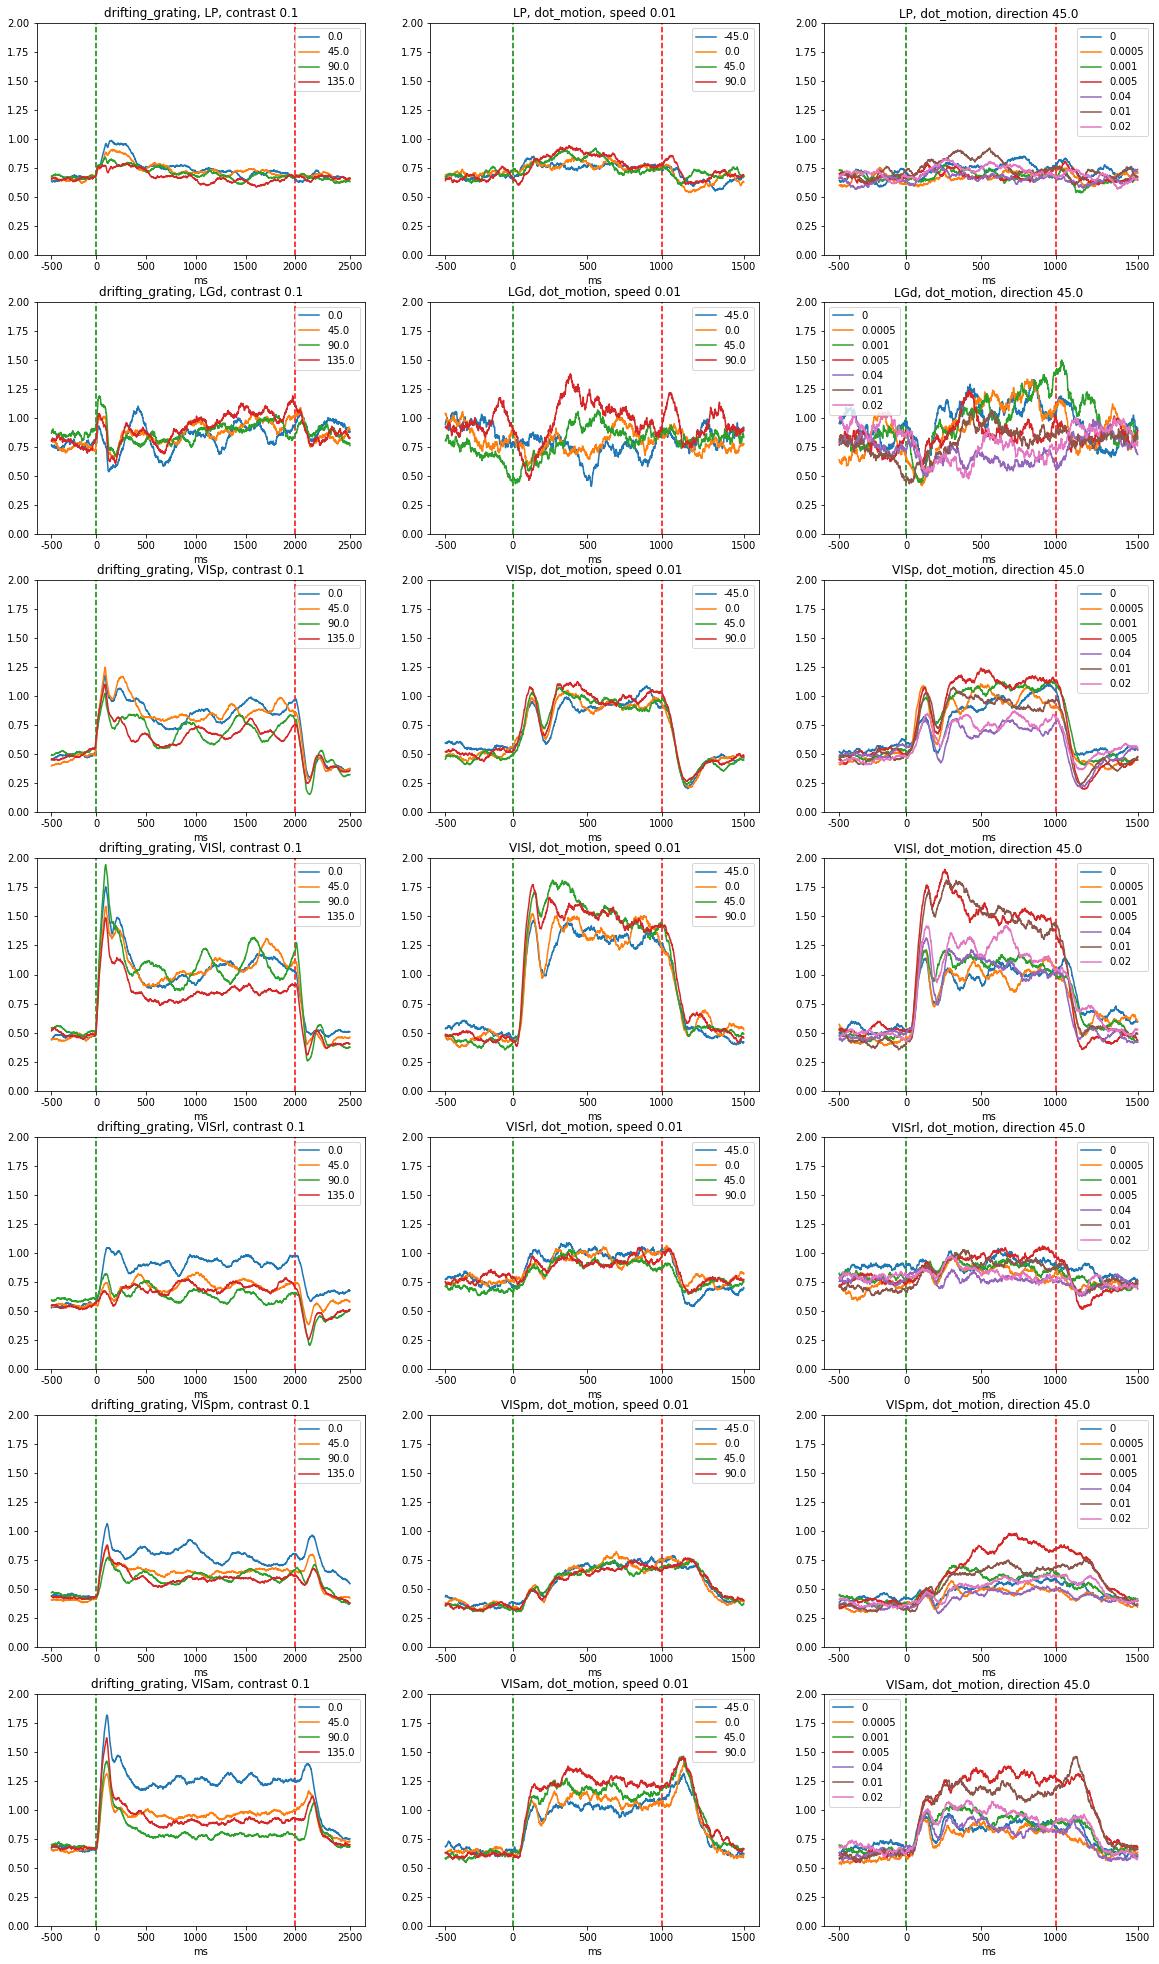

In [15]:
start_time = (blank-window_len/2)/bin
end_time = (period_drift+blank-window_len/2)/bin

f, axes = plt.subplots(nrows=len(areas), ncols=3, figsize=(20, 35))

for i, area in enumerate(areas):

    axes[i][0].plot(drift_response_curve[i, :, 1, :].T)
    axes[i][0].set_ylim(0, 2)
    axes[i][0].vlines(x=start_time, ymin=0, ymax=2, linestyles='dashed', color='g')
    axes[i][0].vlines(x=end_time, ymin=0, ymax=2, linestyles='dashed', color='r')
    axes[i][0].legend(ori_list)
    axes[i][0].set_title(f'drifting_grating, {area}, contrast 0.1')
    axes[i][0].set_xticks([0, start_time, start_time+500, start_time+1000, start_time+1500, end_time, 3000])
    axes[i][0].set_xticklabels([-500, 0, 500, 1000, 1500, 2000, 2500])
    axes[i][0].set_xlabel('ms')

start_time = (blank-window_len/2)/bin
end_time = (period_dot+blank-window_len/2)/bin

for i, area in enumerate(areas):

    axes[i][1].plot(dot_response_curve[i, :, 5, :].T)
    axes[i][1].set_ylim(0, 2)
    axes[i][1].vlines(x=start_time, ymin=0, ymax=2, linestyles='dashed', color='g')
    axes[i][1].vlines(x=end_time, ymin=0, ymax=2, linestyles='dashed', color='r')
    axes[i][1].legend(dir_list)
    axes[i][1].set_title(f'{area}, dot_motion, speed 0.01')
    axes[i][1].set_xticks([0, start_time, start_time+500, end_time, 2000])
    axes[i][1].set_xticklabels([-500, 0, 500, 1000, 1500])
    axes[i][1].set_xlabel('ms')

    axes[i][2].plot(dot_response_curve[i, 2, :, :].T)
    axes[i][2].set_ylim(0, 2)
    axes[i][2].vlines(x=start_time, ymin=0, ymax=2, linestyles='dashed', color='g')
    axes[i][2].vlines(x=end_time, ymin=0, ymax=2, linestyles='dashed', color='r')
    axes[i][2].legend(sp_list)
    axes[i][2].set_title(f'{area}, dot_motion, direction 45.0')
    axes[i][2].set_xticks([0, start_time, start_time+500, end_time, 2000])
    axes[i][2].set_xticklabels([-500, 0, 500, 1000, 1500])
    axes[i][2].set_xlabel('ms')

plt.show()